# Main topics extraction from restaurants negative reviews

This project will consist in extracting subjects of negative reviews. We will acquire the data throught the API and then with the dataset.

Then, we will process the reviews throught natural language processing techniques and extract the topics via [Latent Dirichlet Allocation](https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation).

## Data acquisition

We will explore two different ways to extract data :
1. From the API
2. Downloading the dataset

### API data acquisition

In [2]:
import requests
import json
from urllib.parse import quote

# Please store your secret variables in a ./credentials.py file
from credentials import API_KEY, CLIENT_ID

def request(host, path, api_key, url_params=None, verbose = True):
    """Given your API_KEY, send a GET request to the API.
    Args:
        host (str): The domain host of the API.
        path (str): The path of the API after the domain.
        API_KEY (str): Your API Key.
        url_params (dict): An optional set of query parameters in the request.
    Returns:
        dict: The JSON response from the request.
    Raises:
        HTTPError: An error occurs from the HTTP request.
    """
    url_params = url_params or {}
    url = '{0}{1}'.format(host, quote(path.encode('utf8')))
    headers = {
        'Authorization': 'Bearer %s' % api_key,
    }

    if verbose == True : print(u'Querying {0} ...'.format(url))

    response = requests.request('GET', url, headers=headers, params=url_params)

    return response.json()

Because the API limits us to querying 50 business at the time, we shall use an offset parameter at each call to get the 50 following businesses instead of the 50 first businesses.

In [3]:
import pandas as pd

# Get the first 200 business
business_nb = 200

querried_businesses = []

while (len(querried_businesses) < business_nb):
    query_response = request(
                        'https://api.yelp.com/v3/',
                        'businesses/search',
                        API_KEY,
                        url_params={
                            'location': 'New York City',
                            'limit' : 50,
                            'offset' : len(querried_businesses),
                        }
                    )

    querried_businesses = querried_businesses + query_response['businesses']
    
print(f"querried {len(querried_businesses)} businesses")
business_df = pd.DataFrame(querried_businesses)
business_df.head()

Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
querried 200 businesses


,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,distance
0,H4jJ7XB3CetIr1pg56CczQ,levain-bakery-new-york,Levain Bakery,https://s3-media3.fl.yelpcdn.com/bphoto/DH29qe...,False,https://www.yelp.com/biz/levain-bakery-new-yor...,8932,"[{'alias': 'bakeries', 'title': 'Bakeries'}]",4.5,"{'latitude': 40.779961, 'longitude': -73.980299}",[],$$,"{'address1': '167 W 74th St', 'address2': '', ...",+19174643769,(917) 464-3769,8369.262425
1,V7lXZKBDzScDeGB8JmnzSA,katzs-delicatessen-new-york,Katz's Delicatessen,https://s3-media1.fl.yelpcdn.com/bphoto/mrIdx2...,False,https://www.yelp.com/biz/katzs-delicatessen-ne...,13676,"[{'alias': 'delis', 'title': 'Delis'}, {'alias...",4.0,"{'latitude': 40.722237, 'longitude': -73.9875259}","[delivery, pickup]",$$,"{'address1': '205 E Houston St', 'address2': '...",+12122542246,(212) 254-2246,1952.370624
2,44SY464xDHbvOcjDzRbKkQ,ippudo-ny-new-york-7,Ippudo NY,https://s3-media1.fl.yelpcdn.com/bphoto/zF3Egq...,False,https://www.yelp.com/biz/ippudo-ny-new-york-7?...,10278,"[{'alias': 'ramen', 'title': 'Ramen'}]",4.0,"{'latitude': 40.73092, 'longitude': -73.99015}","[delivery, pickup]",$$,"{'address1': '65 4th Ave', 'address2': '', 'ad...",+12123880088,(212) 388-0088,2854.301267
3,xEnNFXtMLDF5kZDxfaCJgA,the-halal-guys-new-york-2,The Halal Guys,https://s3-media2.fl.yelpcdn.com/bphoto/pqcdqG...,False,https://www.yelp.com/biz/the-halal-guys-new-yo...,9886,"[{'alias': 'foodstands', 'title': 'Food Stands...",4.0,"{'latitude': 40.761861, 'longitude': -73.979306}","[delivery, pickup]",$,"{'address1': 'W 53rd Street And 6th Ave', 'add...",+13475271505,(347) 527-1505,6399.019110
4,KFnr0CGsHQ2ABFHbLNtobQ,central-park-conservancy-new-york,Central Park Conservancy,https://s3-media2.fl.yelpcdn.com/bphoto/2QeE4Z...,False,https://www.yelp.com/biz/central-park-conserva...,2649,"[{'alias': 'parks', 'title': 'Parks'}]",5.0,"{'latitude': 40.764266, 'longitude': -73.971656}",[],NaN,"{'address1': '14 E 60th St', 'address2': '', '...",+12123106600,(212) 310-6600,6814.558070


In [4]:
nb_business_to_get_reviews = 50
reviews_businesses = business_df.loc[:nb_business_to_get_reviews-1, : ]

querried_reviews = []

for business_id in reviews_businesses['id']:
    querried_reviews += request(
                        'https://api.yelp.com/v3/',
                        f'businesses/{business_id}/reviews',
                        API_KEY,
                        url_params={
                            'locale': 'en_US',
                        }, 
                        verbose=False
                    )['reviews']

print(f"querried {len(querried_reviews)} reviews of {nb_business_to_get_reviews} businesses")
reviews_df = pd.DataFrame(querried_reviews)
reviews_df.head()

querried 150 reviews of 50 businesses


,id,url,text,rating,time_created,user
0,cWY577FqTCEkQ4M30OHvkg,https://www.yelp.com/biz/levain-bakery-new-yor...,Great coffee! Only downside is that there is ...,5,2022-05-17 04:40:25,"{'id': 'm0j4ToaIvYfrkI80rJuvcg', 'profile_url'..."
1,XgZxA5MgvW3XGXcBKdKOBA,https://www.yelp.com/biz/levain-bakery-new-yor...,/) /)\n( )\n/ づ づ ~ ABSOLUTELY DIVINE! T...,5,2022-06-18 05:07:56,"{'id': 'aR1ybzRc1sNY5fyLVomL3Q', 'profile_url'..."
2,4Vp1X2ndsq7FkhkD-cgPjw,https://www.yelp.com/biz/levain-bakery-new-yor...,"Great, rich cookies. Huge cookies. But that's ...",3,2022-06-20 23:42:24,"{'id': 'D7LdztEvnTbLznpAv3wMpw', 'profile_url'..."
3,8jRKPpYcw7aYgrBJx-_nWQ,https://www.yelp.com/biz/katzs-delicatessen-ne...,"Everything always good, just remember prices a...",5,2022-05-25 03:28:04,"{'id': '7XnZxrjhyuIEQr_UCI-D8A', 'profile_url'..."
4,r_Oe7FbNAc8il1qWywXr9g,https://www.yelp.com/biz/katzs-delicatessen-ne...,"Get the pastrami, don't overthink it! It's del...",5,2022-06-21 16:16:33,"{'id': 'eg5dkYSoNBLaFivo4PxV1Q', 'profile_url'..."


We would have preferred to filter negative review when calling the API but unfortunately, the API doesn't allow filtering. So we have to do it manually later.

> **Can I change which reviews are returned for an API query ?**
> 
> In order to maintain a consistent Yelp experience across all platforms, the Yelp API uses a variety of factors to determine and return a business’s top review excerpts. The sort order is determined by recency, user voting, and other review quality factors to help consumers make informed decisions. The Yelp API cannot be configured to return alternative or hand-picked review excerpts.


However, this API calling method is not ideal because it waste a lot of bandwith for each call, requests unwanted (not filtered) data and makes internet acces required.

So in order to avoid this, we will store in csv file the already aquired data and get the new data from a dataset.

In [6]:
prefered_file = '.csv'

if prefered_file == '.csv':
    reviews_df.to_csv('reviews.csv', index=False)
elif prefered_file == '.xlsx':
    reviews_df.to_excel('reviews.xlsx', index=False)

### Dataset data acquisition

You can download the dataset from [here](https://www.yelp.com/dataset/download).
You'll download a tar file and after extracted, you must refer to the documentation to see if it is another .tar file or .tgz file.

#### Businesses

In [7]:
import simplejson as json

business_json_file  = './Dataset/yelp_dataset/yelp_academic_dataset_business.json'

business = []
for line in open(business_json_file, encoding='utf-8'):
    business.append(json.loads(line))

print(f"Imported {len(business)} businesses from the json file")
business_df = pd.DataFrame(business)
business_df.head()

Imported 150346 businesses from the json file


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


#### Reducing the size of the dataset via type assignation

One thing that can lead to have massive dataFrames is because pandas (and python in general) is assigning types dynamically to the columns. We can lower the dataFrame size by assigning exactly the type we need.

In [8]:
from sys import getsizeof

start_size = getsizeof(business_df)/(1024.0**3)
print('Dataframe size: %2.2f GB'%start_size)
business_df.dtypes

Dataframe size: 0.17 GB


business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
attributes       object
categories       object
hours            object
dtype: object

In [9]:
business_df['state'] = business_df['state'].astype('category')
business_df['latitude'] = business_df['latitude'].astype('float32')
business_df['longitude'] = business_df['longitude'].astype('float32')
business_df['stars'] = business_df['stars'].astype('uint8')
business_df['is_open'] = business_df['is_open'].apply(lambda x: x == 1)


end_size = getsizeof(business_df)/(1024.0**3)
print('Dataframe size: %2.2f GB'%end_size)

Dataframe size: 0.16 GB


Unforuntaley, even if this type of manipulation can be very useful, in this case, it made us lose only about 10MB of memory.

In [10]:
business_one_star_df = business_df.loc[business_df.loc[:,'stars'] == 1,:]
print(f"Number of businesses with one star rating: {len(business_one_star_df)} of {len(business_df)}")

Number of businesses with one star rating: 6918 of 150346


#### Reviews

Because there are a lot of reviews, we will only use the first 10 000 reviews (~1 mn).

In [12]:
reviews_json_file  = './Dataset/yelp_dataset/yelp_academic_dataset_review.json'

nb_reviews_to_load = 10000

reviews_df = pd.DataFrame(columns=['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date'])

with open(reviews_json_file, encoding='utf-8') as f:

    for line in f:
        json_line = json.loads(line)
        if json_line['stars'] == 1:

            reviews_df = pd.concat([reviews_df, pd.DataFrame([json.loads(line)])], ignore_index=True)

            if reviews_df.shape[0] >= nb_reviews_to_load:
                break
            
            if reviews_df.shape[0] % 2000 == 0:
                print(f"{reviews_df.shape[0]} reviews loaded")

print(f"{reviews_df.shape[0]} reviews gathered")
reviews_df.head()

2000 reviews loaded
4000 reviews loaded
6000 reviews loaded
8000 reviews loaded
10000 reviews gathered


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31
1,TcCcHzc3L6Aboq3DteEfZA,OuatwND396ZQxm2zK8WlUQ,jNL5KUPz2-tHUJM__ysSaw,1.0,1,0,0,If you want to pay for everything a la carte t...,2014-08-24 20:14:12
2,qdzNocGBnh8U-cvE_N8qbA,Fq7d14GDAsGjDoojP_ygOQ,pAgtmlIGqFYaWdBoCUeitw,1.0,3,0,0,The TV shows are $4.99 and they have commercia...,2012-12-04 02:40:49
3,PDHRlnEdkEcwATry4w71PQ,UsBxLh14sUpO8SdeqIiGOA,Wy8Hswf2cLQGRZN6armkag,1.0,1,0,0,"If I could give it a zero, I would. I order a ...",2011-08-24 23:07:08
4,5obXxR0b94b5q6j1zYCAzw,3inG_FUhm28tUJc0zZ2fCg,aY_n9RSaD2Yw09jSFFePew,1.0,0,0,0,We visited once and were very disappointed in ...,2017-08-16 15:43:19


We do the same manipulation we did for the business dataFrame, size reduction by type assignation.

In [13]:
from sys import getsizeof

start_size = getsizeof(reviews_df)/(1024.0**3)
print('Dataframe size: %2.2f GB'%start_size)

print(reviews_df.dtypes)


reviews_df['stars'] = reviews_df['stars'].astype('uint8')
reviews_df['date'] = pd.to_datetime(reviews_df['date'])


end_size = getsizeof(reviews_df)/(1024.0**3)
print('Dataframe size: %2.2f GB'%end_size)

Dataframe size: 0.01 GB
review_id      object
user_id        object
business_id    object
stars          object
useful         object
funny          object
cool           object
text           object
date           object
dtype: object
Dataframe size: 0.01 GB


## Reviews preprocessing

Because we cannot extract topics from the raw reviews, we first need to use many useful preprocessing techniques.

### Tokenization

Tokenization is the process of breaking a sentence into a list of words.

In [24]:
import nltk

tokenized_reviews = reviews_df.loc[:, 'text'].apply(lambda text: nltk.RegexpTokenizer(r'\w+').tokenize(text))
print("Reviews tokenized !")
print("\nEg :\n")
print(f"First review before tokenization:\n{reviews_df.loc[0, 'text']}\n")
print(f"First review after tokenization (only the first words):\n{tokenized_reviews[0][:10]}")

Reviews tokenized !

Eg :

First review before tokenization:
I am a long term frequent customer of this establishment. I just went in to order take out (3 apps) and was told they're too busy to do it. Really? The place is maybe half full at best. Does your dick reach your ass? Yes? Go fuck yourself! I'm a frequent customer AND great tipper. Glad that Kanella just opened. NEVER going back to dmitris!

First review after tokenization (only the first words):
['I', 'am', 'a', 'long', 'term', 'frequent', 'customer', 'of', 'this', 'establishment']


### Stopwords removal

Stopwords are words that are common and often don't carry much meaning. It is usually better to remove them before doing any other preprocessing.

In [45]:
stop_words = set(nltk.corpus.stopwords.words('english'))

tok_rev_cleaned = [ [word for word in review if not word.lower() in stop_words] for review in tokenized_reviews]
print("Reviews cleaned !")
print("\nEg :\n")
print(f"First review before removing the stopwords (only the first words):\n{tokenized_reviews[0][:10]}\n")
print(f"First review after removing the stopwords (only the first words):\n{tok_rev_cleaned[0][:10]}")

Reviews cleaned !

Eg :

First review before removing the stopwords (only the first words):
['I', 'am', 'a', 'long', 'term', 'frequent', 'customer', 'of', 'this', 'establishment']

First review after removing the stopwords (only the first words):
['long', 'term', 'frequent', 'customer', 'establishment', 'went', 'order', 'take', '3', 'apps']


### Size reducing

Reviews can be difficult to process if they have too many words because they are more likely to contain different subjects of insatisfaction. Because we only want one subject of insatisfaction per review, we will remove the too long reviews.

We also could have split these reviews into more small ones but we would not have been sure every reviews would have a subject of insatisfaction so we won't use this technique.

We will remove reviews over 100 (cleaned) words


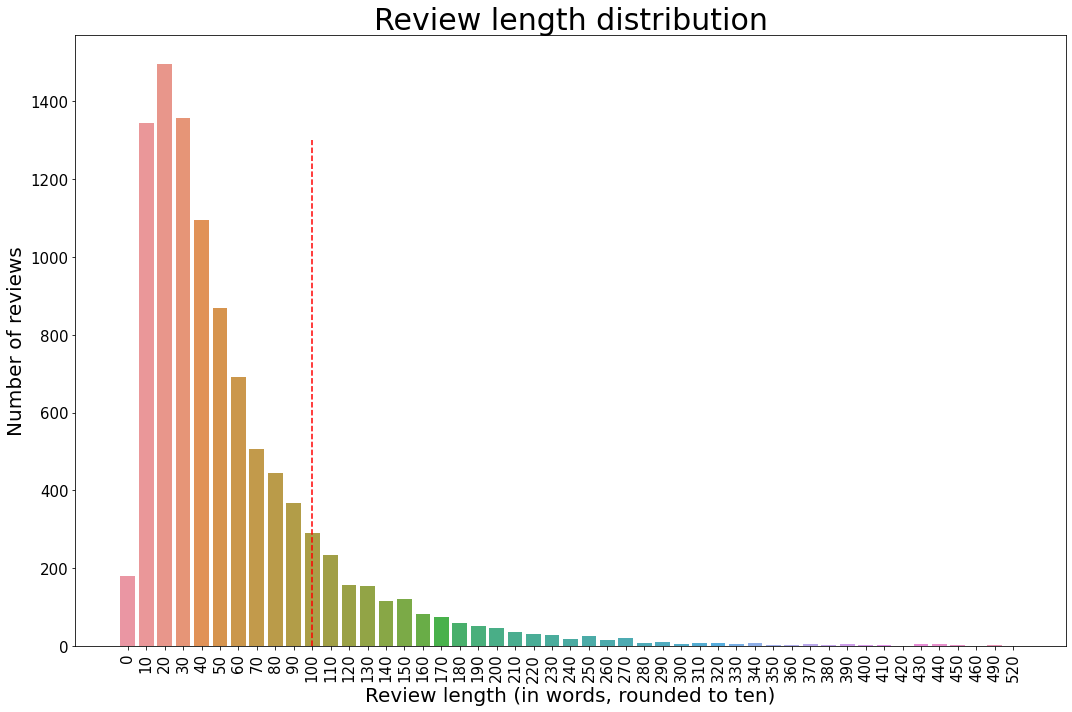

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
review_lengths = [(len(review)//10)*10 for review in tok_rev_cleaned]
sns.countplot(x = review_lengths)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.title('Review length distribution', fontsize=30)
plt.xlabel('Review length (in words, rounded to ten)', fontsize=20)
plt.ylabel('Number of reviews', fontsize=20)
plt.vlines(x=10, ymin=0, ymax=1300, linestyles='dashed', color='red')
# print figures on white
plt.gcf().set_facecolor('white')
plt.tight_layout()

print("We will remove reviews over 100 (cleaned) words")

In [47]:
print(f"Before removing the long reviews : {len(tok_rev_cleaned)} reviews")

reviews_cleaned = [review for review in tok_rev_cleaned if len(review) <= 100]
print(f"After removing the long reviews : {len(reviews_cleaned)} reviews")

Before removing the long reviews : 10000 reviews
After removing the long reviews : 8384 reviews


### Lemmatization

Lemmatization is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item. Lemmatization is similar to stemming (only keeping the radical of a word) but it brings context to the words. So it links words with similar meanings to one word.

In [56]:
nltk.download('omw-1.4')
nltk.download('wordnet')

lemmatizer = nltk.stem.WordNetLemmatizer()

lema_tok_cle_reviews = [[lemmatizer.lemmatize(word) for word in review] for review in reviews_cleaned]
print("Reviews lematized !")

lematization_difference_array = []
for not_lema_review , lema_review in zip(reviews_cleaned, lema_tok_cle_reviews):
    if len(lematization_difference_array) == 10:
        break
    for not_lema, lema in zip(not_lema_review, lema_review):
        if not_lema != lema:
            lematization_difference_array.append(f"{not_lema} != {lema}")
        if len(lematization_difference_array) == 10:
            break
print("\nLematization differences :")
[print(difference) for difference in lematization_difference_array]
print('')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\augustin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\augustin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Reviews lematized !

Lematization differences :
ass != as
shows != show
commercials != commercial
less != le
hotels != hotel
bites != bite
minutes != minute
places != place
setups != setup
refills != refill



## Reviews topics analysis

Now that our reviews are cleaned, we can start to analyse them. We do not need that every word is kept in its review so we will do a bag of word, basically a counter of the words in the reviews.

### WordCloud

From now, we cannot install the wordcloud library.

In [27]:
# from wordcloud import wordcloud
# words = [[word for word in review] for review in reviews_cleaned]
# wordcloud = WordCloud(background_color = 'white', max_words = 50).generate(words)
# plt.show()

### Creating a bag of words

Bag of words is a series of technique to reprensent the frequency of a word in a corpus of text (reviews) but also take into account the importance of the word.

1. Tokenizing the reviews (splitting the reviews into words)
2. Counting (make a list of all the words in all the reviews and count for each review how many times each word appears)
3. Normalizing (reducing the importance of a word if it is too common)

To show the importance of the Normalization step, we will draw a count plot of the words with and without normalization.

In [147]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

cleaned_reviews = [' '.join(review) for review in lema_tok_cle_reviews]

counter = CountVectorizer()
countVectReviews = counter.fit_transform(cleaned_reviews)
print("Count vectorizer fitted !")

tfidf = TfidfTransformer()
TfIdfVectReviews = tfidf.fit_transform(countVectReviews)
print("Tf-Idf transformer fitted !")

Count vectorizer fitted !
Tf-Idf transformer fitted !


In [148]:
counter_df = pd.DataFrame(countVectReviews.toarray(), columns=counter.get_feature_names_out()).sum(axis=0).reset_index()
counter_df = counter_df.sort_values(by=0, ascending=False)

tfidf_df = pd.DataFrame(TfIdfVectReviews.toarray(), columns=counter.get_feature_names_out()).sum(axis=0).reset_index()
tfidf_df = tfidf_df.sort_values(by=0, ascending=False)

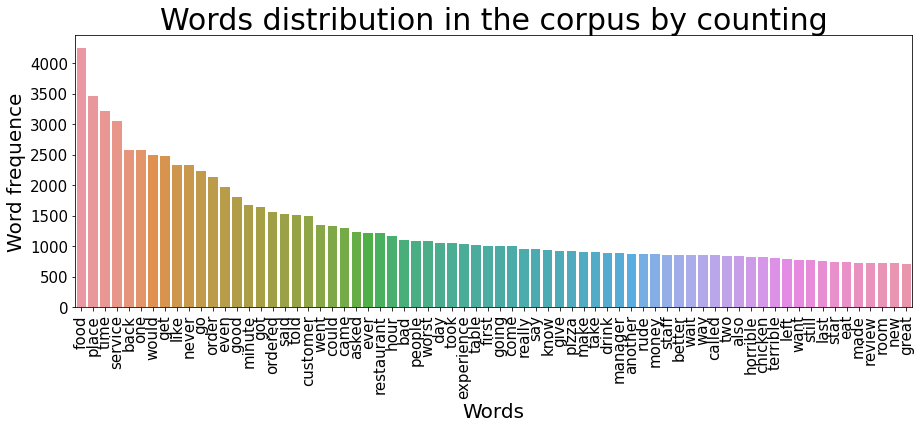

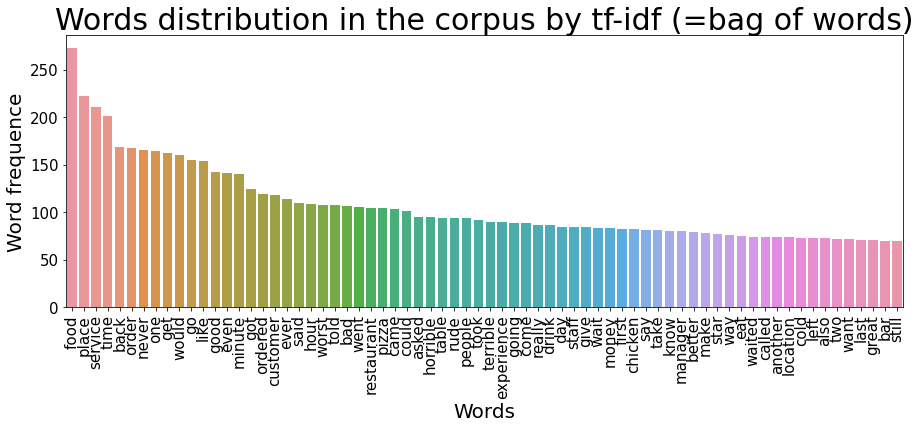

In [150]:
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(data = counter_df[:70], x = 'index', y = 0, ax = ax)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.title('Words distribution in the corpus by counting', fontsize=30)
plt.xlabel('Words', fontsize=20)
plt.ylabel('Word frequence', fontsize=20)
# print figures on white
plt.gcf().set_facecolor('white')
plt.show()

fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(data = tfidf_df[:70], x = 'index', y = 0, ax = ax)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.title('Words distribution in the corpus by tf-idf (=bag of words)', fontsize=30)
plt.xlabel('Words', fontsize=20)
plt.ylabel('Word frequence', fontsize=20)
# print figures on white
plt.gcf().set_facecolor('white')
plt.show()

### Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation

Both NMF and LDA are dimension reduction techniques that we can use to extract topics from reviews.

NMF is a factorization method used for example for dimensionality reduction, source separation or topic extraction. It only works with non negative data, which is perfect because we use some sort of word counter. It try to factorize the X (data) matrix into two W and H other matrix with W.H ~= X. It can takes different beta_loss values that are ways to calculate the distance from the W.H matrix to the data matrix.

LDA is like a PCA but won't try to maximize the variance of the data but the separation of the categories (by minimizing the variance in the categorie and the distance from center of the categorie to the other categories).

From [here](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py)

Loading dataset...
done in 0.000s.
Extracting tf-idf features for NMF...
done in 0.319s.
Extracting tf features for LDA...
done in 0.312s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=8000 and n_features=1000...
done in 0.273s.


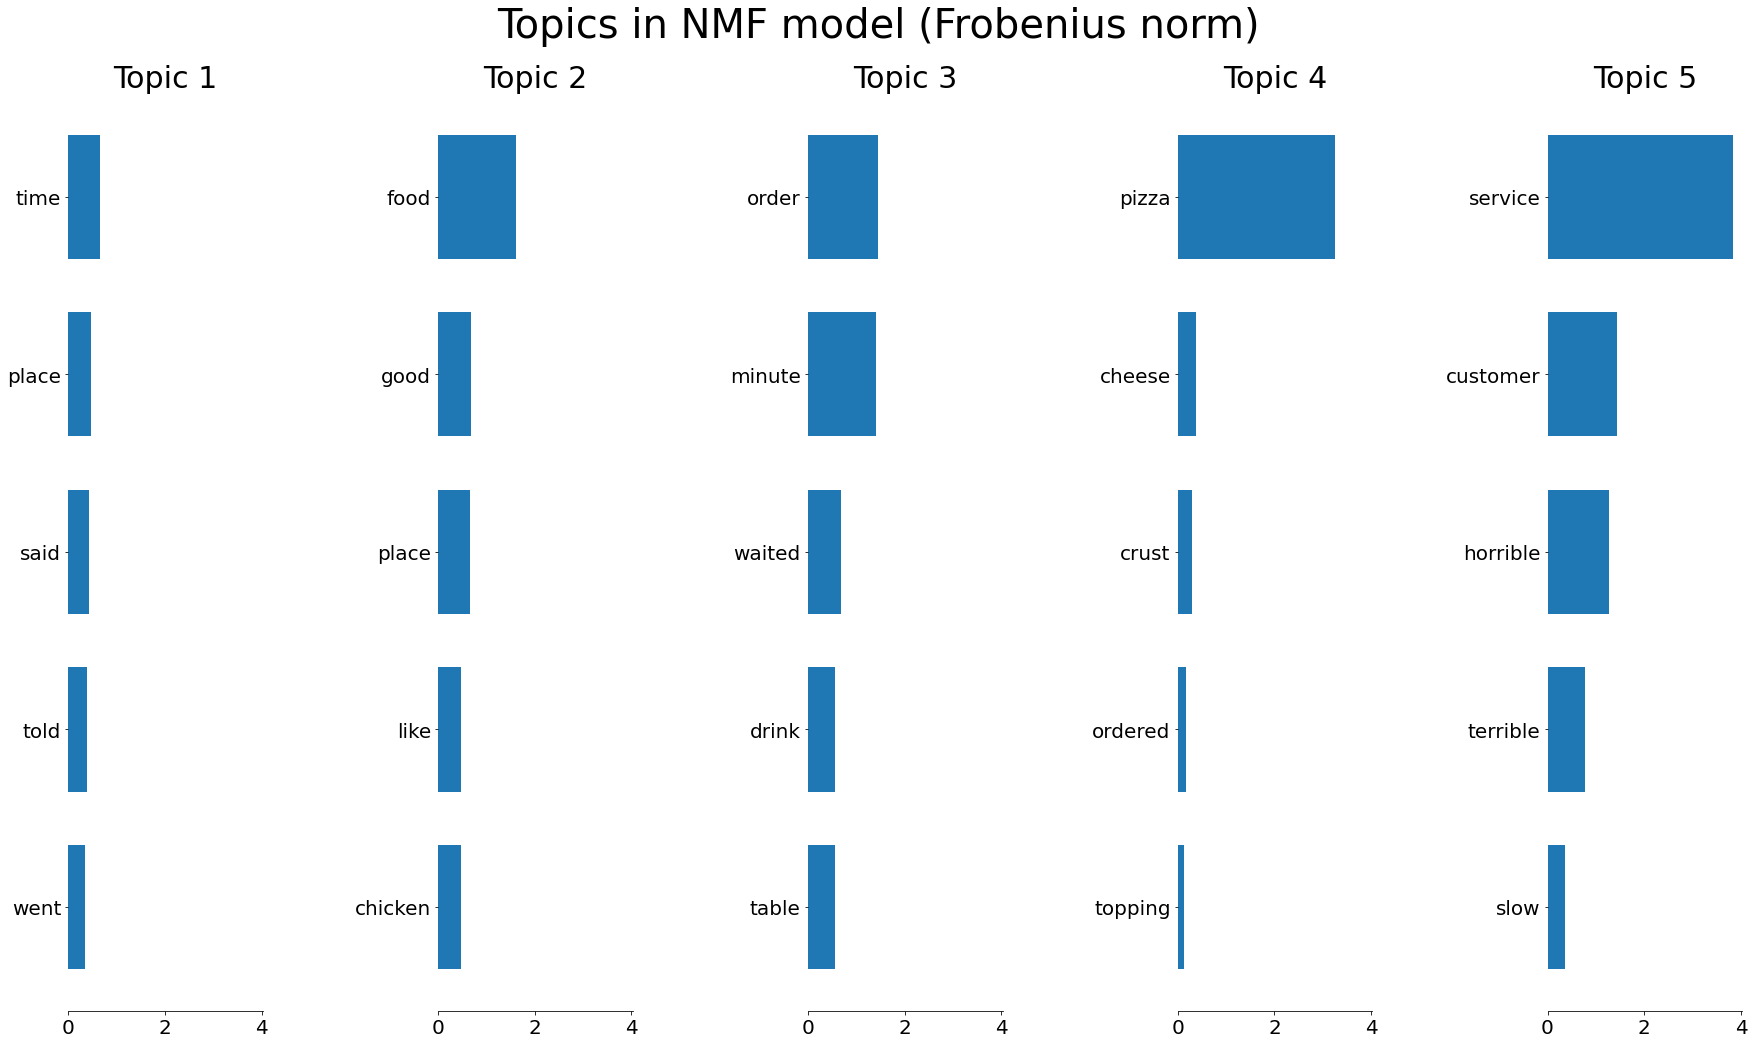



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=8000 and n_features=1000...
done in 4.760s.


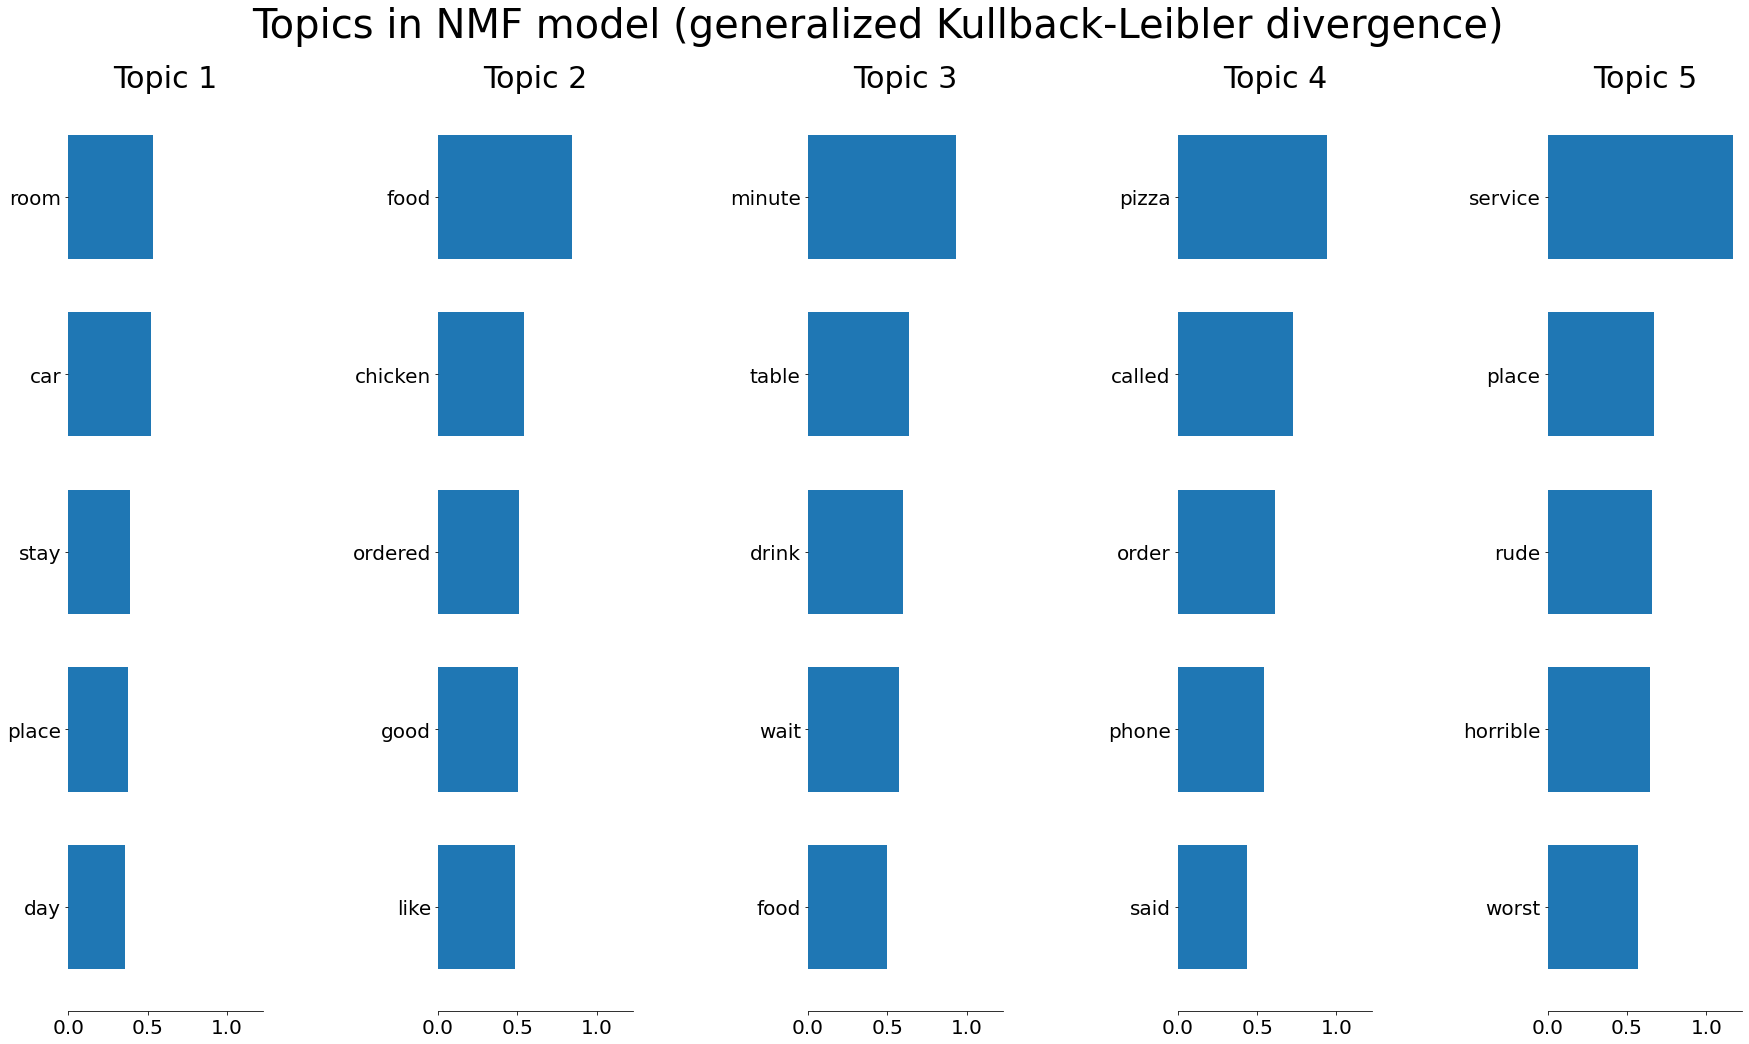



 Fitting LDA models with tf features, n_samples=8000 and n_features=1000...
done in 15.397s.


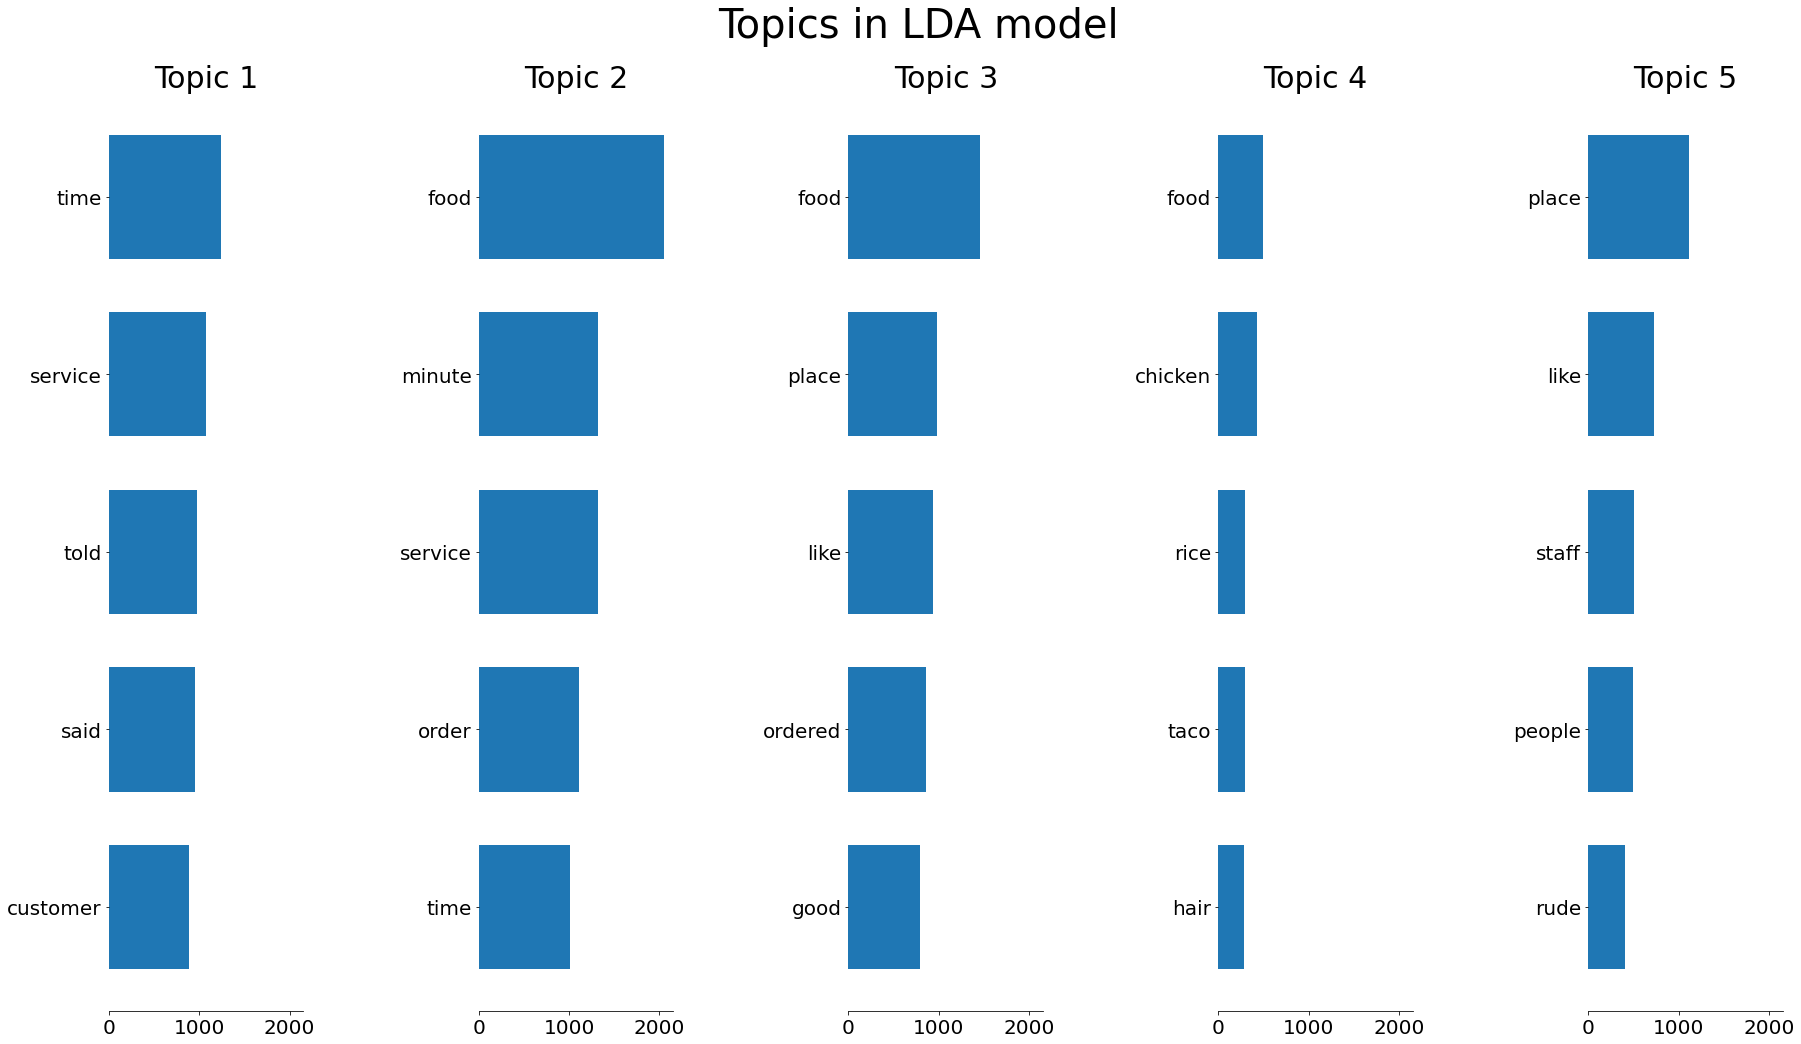

In [158]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# Modified : Augustin BAR
# License: BSD 3 clause

from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, MiniBatchNMF, LatentDirichletAllocation

n_samples = 8000
n_features = 1000
n_components = 5
n_top_words = 5
batch_size = 128
init = "nndsvda"


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    
    # print figures on white
    plt.gcf().set_facecolor('white')
    plt.show()

print("Loading dataset...")
t0 = time()
data = cleaned_reviews
data_samples = data[:n_samples]
print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (n_samples, n_features)
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)

# Fit the NMF model
print(
    "\n" * 2,
    "Fitting the NMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

# Don't need the miniBatchNMF model because NMF model fit in little time

# # Fit the MiniBatchNMF model
# print(
#     "\n" * 2,
#     "Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf "
#     "features, n_samples=%d and n_features=%d, batch_size=%d..."
#     % (n_samples, n_features, batch_size),
# )
# t0 = time()
# mbnmf = MiniBatchNMF(
#     n_components=n_components,
#     random_state=1,
#     batch_size=batch_size,
#     init=init,
#     beta_loss="frobenius",
#     alpha_W=0.00005,
#     alpha_H=0.00005,
#     l1_ratio=0.5,
# ).fit(tfidf)
# print("done in %0.3fs." % (time() - t0))


# tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
# plot_top_words(
#     mbnmf,
#     tfidf_feature_names,
#     n_top_words,
#     "Topics in MiniBatchNMF model (Frobenius norm)",
# )

# # Fit the MiniBatchNMF model
# print(
#     "\n" * 2,
#     "Fitting the MiniBatchNMF model (generalized Kullback-Leibler "
#     "divergence) with tf-idf features, n_samples=%d and n_features=%d, "
#     "batch_size=%d..." % (n_samples, n_features, batch_size),
# )
# t0 = time()
# mbnmf = MiniBatchNMF(
#     n_components=n_components,
#     random_state=1,
#     batch_size=batch_size,
#     init=init,
#     beta_loss="kullback-leibler",
#     alpha_W=0.00005,
#     alpha_H=0.00005,
#     l1_ratio=0.5,
# ).fit(tfidf)
# print("done in %0.3fs." % (time() - t0))

# tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
# plot_top_words(
#     mbnmf,
#     tfidf_feature_names,
#     n_top_words,
#     "Topics in MiniBatchNMF model (generalized Kullback-Leibler divergence)",
# )

print(
    "\n" * 2,
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")



## Conclusion

I (personnally) find the NMF model with generalized Kullback-Leibler divergence topics interesting.

We can sort the topics of insatisfaction like this :
1. No place to park the car (by "room", "car", "stay", "place", "day")
2. The chicken is not good (by "food", "ordered", "chicken", "good", "like")
3. The waiting time is too long (by "minute", "table", "drink", "wait", "food")
4. The pizza call goes wrong (by "pizza", "called", "order", "phone", "said")
5. The service is not polite enough (by "service", "place", "rude", "horrible", "worst")